# Statistics
Date : 27/07/2020

Load the speakers, show the time each speaker speaks according to a duration filter.
The aim is to verify that the corpus is uniform.

In [1]:
import torch

In [2]:
# useful imports
from IPython.display import SVG, Audio, display
import subprocess
import pandas as pd
import numpy as np
from tqdm import tqdm
import librosa
%matplotlib inline
import os
from matplotlib import pyplot as plt

# voicemap imports
from voicemap.datasets import LibriSpeech, SpeakersInTheWild, CommonVoice, TCOF, ClassConcatDataset, SpectrogramDataset, DatasetFolder 
from config import PATH, DATA_PATH

## Parameters

In [39]:
n_seconds = 3 # Use only the samples longer than 'n_seconds'
downsampling = 4
sampling_rate = 16000

## Load data

In [7]:
df_train = pd.read_csv(f"{DATA_PATH}/train_durations_per_speaker.csv")
df_test = pd.read_csv(f"{DATA_PATH}/val_durations_per_speaker.csv")
df_global = pd.read_csv(f"{DATA_PATH}/global_durations_per_speaker.csv")

In [8]:
df_train.speaker_id.describe()

count                                                370731
unique                                                 3699
top       CommonVoice_d81061aa53fcaee5c245e2b24a26ae50dd...
freq                                                   7721
Name: speaker_id, dtype: object

In [10]:
df_test.speaker_id.describe()

count        30527
unique        4891
top       TCOF_253
freq           120
Name: speaker_id, dtype: object

In [9]:
df_global.speaker_id.describe()

count                                                401258
unique                                                 7941
top       CommonVoice_d81061aa53fcaee5c245e2b24a26ae50dd...
freq                                                   7721
Name: speaker_id, dtype: object

In [11]:
df_global

,speaker_id,filepath,seconds,dataset_name
0,TCOF_1,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,0.216000,TCOF
1,TCOF_1,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,0.547000,TCOF
2,TCOF_2,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,1.010000,TCOF
3,TCOF_0,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,0.505000,TCOF
4,TCOF_0,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,1.805000,TCOF
5,TCOF_0,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,2.329000,TCOF
6,TCOF_0,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,0.810000,TCOF
7,TCOF_0,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,1.091000,TCOF
8,TCOF_1,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,2.622000,TCOF
9,TCOF_0,/home/profenpoche/voicemap/data/TCOF/Enfants/e...,0.906000,TCOF


## 1. Time spoken for each speaker
Pour un bon entraînement du modèle il faut que chaque classe (locuteur) soit représentée par quasiment autant de temps de parole. On souhaite donc vérifier que les locuteurs ont tous le même temps de parole.

In [42]:
source_df = df_train.loc[df_train['seconds'] > n_seconds]
df = source_df.loc[:, ['speaker_id', 'dataset_name']]
df = df.set_index('speaker_id')
df = df.loc[~df.index.duplicated(keep='first')]

dfGrouped = source_df.groupby(['speaker_id']).sum()
speakers_duration = dfGrouped.join(df)
speakers_duration

,seconds,dataset_name
speaker_id,,
CommonVoice_0003cd846a882cd7b17df3ce941508d16da430599223ef39a4e22226c640afe6ae1e8675e0b5f96175a6de4d322dcf0e67c258fa02b2b61cda05354fdddc5fbb,432.145488,CommonVoice
CommonVoice_000de8f59af10409a1f8e499c2f50b6a5adf2d9ad0f18395af0893345481b8311b1a094787aac8959fc50961f3e94deeacd005df8d478fd261cbf7b508602f0a,1636.423447,CommonVoice
CommonVoice_001b79ad83c8bb7c5591f059b31611157620e20f647eab28720c1dc40baac089bc9d1551e0ea5e0e4bdef30a97afdbb7a1f2e6d325deab3434b9848c0ad95f1e,82.440317,CommonVoice
CommonVoice_003f6010fddda25afa548668d296b4f4d91b8fff30ad32b1b55d1b79028cb9dc611723e109c879fcd83e273f918bf82ef438c4157652c5106e089d01663c02ce,170.040635,CommonVoice
CommonVoice_004a38a23c7b674dd17aa3479d50ef39fd484c38347423e241901eaec25ada7c337d0b2700dd5cd3b6c3a1862ca33336911687b283380c3bd15aa29b0406bee0,46.752154,CommonVoice
CommonVoice_004f7e01f66f710d82b83c614bdc2ac9aba075d95d205258cf28ef8faa2d2a4b62e25e87162c01a20d7e51be22d198b0b55611347e8937c3b679d3517e329ceb,25.536100,CommonVoice
CommonVoice_00511485e714ef2b6eea14ef62f03641ade85f7ce56fba114063c38d8a67208b581b027bbe385f52d51f5b91387a669fbdb5c5b2819942664b2e9852eecc288e,238.296961,CommonVoice
CommonVoice_006015274fb2a0e44ffd95b6624a52ebf90b65f3e9beacd08f30f03a2dfb7f04b5007740d80dcfcb7ee2916cf8836311fa9bdc5ab0636ffc36ad14407d75e51b,190.128844,CommonVoice
CommonVoice_0065fa8b8804fdd89c9ce2b8133b3c45a8fc49676c5547605e9286a4653a8e30599f95f4df577827e6631e52b242624995efba9b33c70da3cbbc80feb9c5ba9b,155.520499,CommonVoice


In [43]:
for dataset_name in ["TCOF", "CommonVoice", "LibriSpeech", "sitw"]:
    subset = speakers_duration.loc[speakers_duration['dataset_name'] == dataset_name]
    print(dataset_name, subset.describe())
    

TCOF            seconds
count   652.000000
mean    185.357974
std     199.428905
min       3.070000
25%      66.253000
50%     126.599500
75%     220.910702
max    1665.390000
CommonVoice             seconds
count   1754.000000
mean     350.840022
std     1696.498393
min        3.024036
25%       72.672268
50%      125.496440
75%      239.413005
max    41963.153968
LibriSpeech            seconds
count  1172.000000
mean   1419.705931
std     185.660190
min     107.445000
25%    1437.504984
50%    1497.637500
75%    1503.986250
max    1515.230063
sitw           seconds
count  119.000000
mean   256.411765
std    108.371881
min     42.000000
25%    183.000000
50%    252.000000
75%    323.500000
max    676.000000


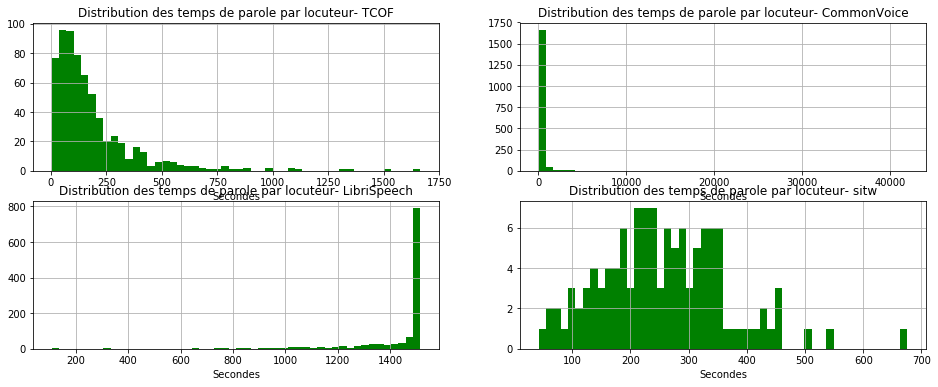

In [44]:
fig, ax = plt.subplots(2,2)
index = 1
for dataset_name in ["TCOF", "CommonVoice", "LibriSpeech", "sitw"]:
    plt.subplot(2,2,index)
    subset = speakers_duration.loc[speakers_duration['dataset_name'] == dataset_name]
    ax = subset['seconds'].hist(figsize=(16,6), bins=50, color="green")
    ax.set_title(f"Distribution des temps de parole par locuteur- {dataset_name}")
    ax.set_xlabel("Secondes");
    index += 1
plt.show()

**On observe une disparité considérable du temps de parole des locuteurs.** Il est nécessaire de réduire le temps de parole de certains locuteurs. Dans CommonVoice, par exemple, deux locuteurs ont plus de 11h d'enregistrement, pour 6982 audios différents. Cela explique pourquoi certains locuteurs sont prédits très souvent (le modèle s'est beaucoup entraîné avec eux).

In [45]:
speakers_duration.seconds.min()

3.0240362811791384

In [35]:
speakers_duration.loc[speakers_duration['seconds'] > 40000]

,seconds,dataset_name
speaker_id,,
CommonVoice_a7c881996f1d72a5bd09e3dcc8aa9994b83ec84a4159253abaded666c911e49199db329e91bdb8554b9ac6d8de0857d1e42932be47806b36e824cfce0528aca7,41943.152834,CommonVoice
CommonVoice_d81061aa53fcaee5c245e2b24a26ae50dd07993e83d7054d016ec26ca7cee18d425f1ba5afc5292b00590265e1c0312305ac42554dd9f0e932b07b2f05047321,42583.631338,CommonVoice


In [36]:
len(df_train.loc[df_train['speaker_id'] == "CommonVoice_a7c881996f1d72a5bd09e3dcc8aa9994b83ec84a4159253abaded666c911e49199db329e91bdb8554b9ac6d8de0857d1e42932be47806b36e824cfce0528aca7"])

6982

In [68]:
display(Audio(rate=4000, data=common_voice[106281][0]))

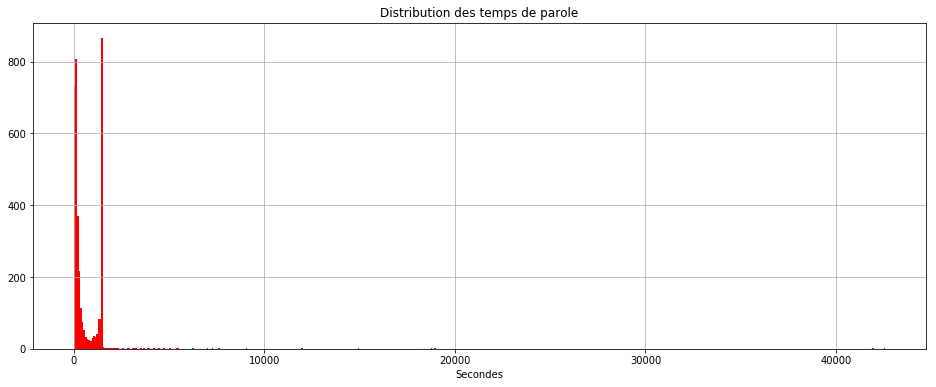

In [88]:
ax = speakers_duration['seconds'].hist(figsize=(16,6), bins=500, color='red')
ax.set_title("Distribution des temps de parole")
ax.set_xlabel("Secondes");

In [ ]:
s = 27948
sampling_rate = sampling_rate / downsampling
for num_sample in range(s, s+5):
    audio_array, speaker = data[num_sample]
    print(f'Speaker = {speaker}, audio_array = {audio_array}')
    display(Audio(data=audio_array,rate=sampling_rate))

In [ ]:
librispeech.df.loc[librispeech.df['speaker_id'] == 14]

In [ ]:
indices = range(len(data))
train_indices, test_indices, _, _ = train_test_split(
    indices,
    indices,
    test_size=0.1,
    # stratify=speaker_ids
)

train = torch.utils.data.Subset(data, train_indices)
val = torch.utils.data.Subset(data, test_indices)
train_loader = DataLoader(train, batch_size=32, num_workers=cpu_count(), shuffle=True, drop_last=False)


In [ ]:
tcof.df.iloc[998,:]

In [ ]:
tcof[998]

In [ ]:
display(Audio(data=tcof[1000][0],rate=4000))